In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

In [2]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [3]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "data",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data, dataloader = load_transformed_fashionMNIST(16, 128)

In [5]:
# Here we are incrementally adding noise to the image starting with very little to all the way up to creating complete junk.
# We start with an initial image,
# Create random noise tensor sampled from normal distribution -> noise
# Multilpy this noise with sqrt(bet_t), where is from the variational scheduler tensor, initially it is very low. This is what decides the amount of noise added
# Add this poroduct to the another product created from image at previous time -> sqrt(1-b_t) * x_t

# This added noisy image sampled from q(x_t | x_t-1) which follows a normal distribution with mean sqrt(1 - B[t]) * x_t and variance torch.sqrt(B[t]) * noise
# This is nothing but Markov Chain, where the current output depends only on the previous output.

In [23]:
# Variational Scheduler = betaT_steps
nrows = 10
ncols = 15

time_steps = nrows * ncols
start = 0.0001
end = 0.02
beta = torch.linspace(start, end, time_steps).to(device)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # Mean Coefficient
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar) # St. Dev. Coefficient

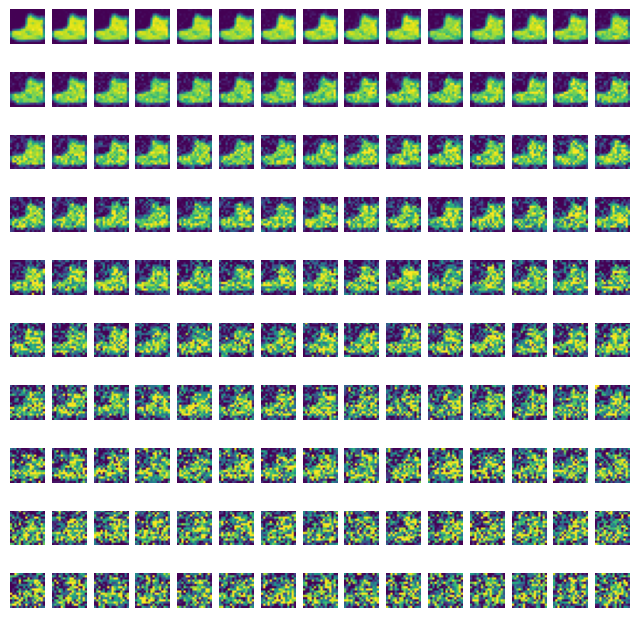

In [24]:
def q(x_0, t):
    """
    q(X_t|X_t-1)
    Samples a new image from distribution q~N(sqrt(1-beta_t) * x_t-1, beta_t)
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t, None, None, None]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t, None, None, None]

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

plt.figure(figsize=(8, 8))
x_0 = data[0][0]
xs = []

for t in range(time_steps):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    show_tensor_image(x_t)
plt.savefig("images\\forward_diffusion_skip.png", bbox_inches='tight')

In [31]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        inputs = input.view(-1, self.input_dim)
        return self.model(inputs)

In [32]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, pading=1):
        super(DownBlock, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(outch, outch, kernel_size=kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),   
            nn.MaxPool2d(2)
        ]

        self.net = nn.Sequential(*layers)
        
    def forward(self, X):
        return self.net(X)

In [33]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, padding=1, strideT=2, outer_paddingT=1):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2*in_ch, out_ch, kernel, stride=strideT, padding=outer_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, X, skip):
        X = torch.cat((X, skip), 1)
        self.net(X)

In [34]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        down_chs = [16, 32, 64]
        up_chs = [64, 32, 16]

        image_size_after_downblock = img_size // (2 ** len(down_chs) - 1)

        # Down Block
        self.down0 = nn.Sequential(
            nn.Conv2d(in_chs, down_chs[0], kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )
        
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*image_size_after_downblock**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*image_size_after_downblock**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])

        # Up Block
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (upchs[0], image_size_after_downblock, image_size_after_downblock)),
            nn.Conv2d(up_chs[0], up_chs[0], kernel, padding=padding),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU()
        )

        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match ouput channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[2], up_chs[2], kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(up_chs[2]),
            nn.ReLU(),
            nn.Conv2d(up_chs[2], in_ch, kernel, stride, padding)
        )
        
        
    def forward(self, X):
        down0 = self.down0(X)
        down1 = self.down1(down1)
        down2 = self.down2(down2)

        to_vec = self.to_vec(down2)

        up0 = self.up0(to_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)

In [23]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)

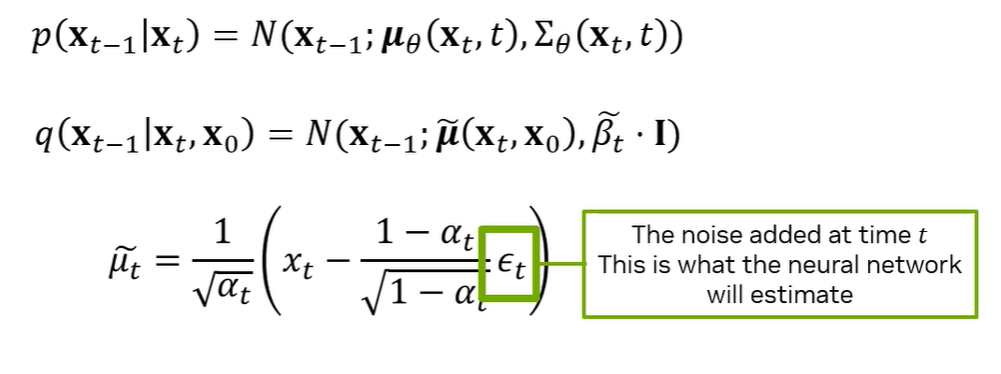

In [25]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    """
    p(X_t-1|X_t)
    """
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise